In [2]:
from phaseedge.storage.store import build_jobstore

js = build_jobstore()

# Query ALL CEModelDocs (payload is under "output" in your DB); load=True rehydrates big fields.
rows = js.query(criteria={"output.kind": "CEModelDoc"}, load=True)
rows = list(rows)  # force evaluation
print("count:", len(rows))

# Print the first ce_key (rehydrated)
for row in rows[:10]:
    doc = row["output"]
    print("ce_key:", doc.get("ce_key"))


count: 8
ce_key: 9f5bcf5bb4a63103c72908b17019fa85df0e04f9b1fd89607b31ed3b31ff769d
ce_key: 781041790a68cc664c64278fed25132d984b3bfbc802d207e41d8626818ff737
ce_key: 76195c946ffef01b43a45fbccfb192c96d55011b69a54b0ccc2d6ff9f6f59bba
ce_key: 6673ff4bac88871cc8b21fc78e2035b39eac75a31198d839a4daaa75c697286f
ce_key: 2553ae57784e9bc4eb05999b8a4dccbc2e326057265292b12c6bf169e0b7285a
ce_key: 72390124f00feed7a0c31023478c4aafe66fc07eec7b48d7718a7c262710947b
ce_key: 54502c0fdf0e0f230e807497747d27b11fecbe47220db16ad93bb960a29b4255
ce_key: d06be615f7a147f2230b86081feb8b57d39cc6dcd88592636283d3739643ca05


In [1]:
from typing import Any, Mapping, Sequence, cast
import math
from collections import defaultdict

import numpy as np
from pymatgen.core import Structure

from smol.cofe import ClusterExpansion

# ---- phaseedge imports (modern-only) ----
from phaseedge.jobs.store_ce_model import lookup_ce_by_key
from phaseedge.science.prototypes import PrototypeName
from phaseedge.jobs.train_ce import (
    featurize_structures,
    lookup_train_refs_by_key,
    predict_from_features,
    compute_stats,
    _n_replace_sites_from_prototype,
)
from phaseedge.schemas.mixture import Mixture, sublattices_from_mixtures
from phaseedge.storage.store import lookup_total_energy_eV
from phaseedge.utils.keys import occ_key_for_structure


# ----------------- helpers: structures, sources, sublattices -----------------

def fmt_mev(x: float | str) -> str:
    if isinstance(x, str):
        return x
    return f"{1e3 * float(x):.3f}"

def _gather_composition_mixtures(sources: Sequence[Mapping[str, Any]]) -> list[Mixture]:
    mixes: list[Mixture] = []
    for s in sources:
        if str(s.get("type", "")).lower() != "composition":
            continue
        for m in s.get("mixtures", []):
            mixes.append(
                Mixture.from_dict(
                    {
                        "composition_map": dict(m["composition_map"]),
                        "K": int(m["K"]),
                        "seed": int(m["seed"]),
                    }
                )
            )
    if not mixes:
        raise RuntimeError("Expected 'composition' mixtures in sources (modern schema).")
    return mixes


def _sublattices_for_doc(doc: Mapping[str, Any]) -> dict[str, tuple[str, ...]]:
    """
    Determine replaceable sublattices for per-site scaling:
      - composition CE: from this doc's mixtures
      - wl_refined CE : from the base (composition) CE's mixtures
    """
    sources = cast(Sequence[Mapping[str, Any]], doc["sources"])
    if not sources:
        raise RuntimeError("CE document missing 'sources'.")
    s0 = sources[0]
    s_type = str(s0.get("type", "")).lower()

    if s_type == "composition":
        return sublattices_from_mixtures(_gather_composition_mixtures(sources))

    if s_type.startswith("wl_refined"):
        base_ce_key = cast(str, s0["base_ce_key"])
        base_doc = lookup_ce_by_key(base_ce_key)
        if not base_doc:
            raise RuntimeError(f"Base CE not found for wl_refined source: {base_ce_key}")
        return sublattices_from_mixtures(_gather_composition_mixtures(cast(Sequence[Mapping[str, Any]], base_doc["sources"])))

    raise RuntimeError(f"Unsupported source type in CE doc: {s_type!r}")

# ----------------- pretty printers ------------------------------------------

def _print_design_metrics(dm: Mapping[str, Any] | None) -> None:
    if not dm:
        print("Design matrix diagnostics: <not available>")
        return

    def _get(name: str, default: float | int | str = float("nan")) -> Any:
        return dm.get(name, default)

    try:
        n_samples = int(_get("n_samples", -1))
        n_features = int(_get("n_features", -1))
        rank = int(_get("rank", -1))

        sigma_max = float(_get("sigma_max", float("nan")))
        sigma_min = float(_get("sigma_min", float("nan")))
        kappa = float(_get("condition_number", float("inf")))
        logdet = float(_get("logdet_xtx", float("nan")))

        lev_mean = float(_get("leverage_mean", float("nan")))
        lev_max = float(_get("leverage_max", float("nan")))
        lev_p95 = float(_get("leverage_p95", float("nan")))

        weighting_applied = bool(_get("weighting_applied", False))
        standardization = str(_get("standardization", "none"))
        zero_var = int(_get("zero_variance_feature_count", 0))
    except Exception:
        print("Design matrix diagnostics: <malformed in CE document>")
        return

    print("Design matrix diagnostics (stored)")
    print("  Samples / Features     : %d / %d" % (n_samples, n_features))
    print("  Rank                   : %d" % rank)
    print("  Sigma max / min        : %.6g / %.6g" % (sigma_max, sigma_min))
    if math.isfinite(kappa):
        print("  Condition number (κ)   : %.6g" % kappa)
    else:
        print("  Condition number (κ)   : inf (rank-deficient or σ_min≈0)")
    print("  log det(XᵀX)           : %.6g" % logdet)
    print("  Leverage mean / p95/max: %.6g / %.6g / %.6g" % (lev_mean, lev_p95, lev_max))
    print("  Weighting applied      : %s" % weighting_applied)
    print("  Standardization        : %s" % standardization)
    print("  Zero-variance columns  : %d" % zero_var)


def _print_mixture_energy_ranges(
    mixture_rows: list[tuple[str, int, float, float, float, float]],
) -> None:
    """
    Each row: (mixture_key, n, E_min_prim, E_max_prim, dE_prim, dE_meV_per_site)
    """
    print("-" * 72)
    print("Mixture energy span (training set)".center(72))
    print("-" * 72)
    hdr = (
        f"{'Mixture (Es/Fm counts)':<42}  {'n':>3}  "
        f"{'E_min (eV/prim)':>14}  {'E_max (eV/prim)':>16}  {'ΔE (eV/prim)':>13}  {'ΔE (meV/site)':>15}"
    )
    print(hdr)
    print("-" * 72)
    for key, n, e_min, e_max, de_prim, de_mev_site in mixture_rows:
        print(
            f"{key:<42}  {n:>3d}  "
            f"{e_min:>14.6f}  {e_max:>16.6f}  {de_prim:>13.6f}  {de_mev_site:>15.3f}"
        )
    print("-" * 72)


def _print_summary(
    *,
    ce_key: str,
    n: int,
    stored_in: Mapping[str, Any],
    recomputed_in: Mapping[str, Any],
    stored_cv: Mapping[str, Any] | None,
    design_metrics: Mapping[str, Any] | None,
    mixture_rows: list[tuple[str, int, float, float, float, float]],
    atol: float,
    rtol: float,
    ok: bool,
) -> None:
    s_mae, s_rmse, s_max = (
        float(stored_in["mae_per_site"]),
        float(stored_in["rmse_per_site"]),
        float(stored_in["max_abs_per_site"]),
    )
    r_mae, r_rmse, r_max = (
        float(recomputed_in["mae_per_site"]),
        float(recomputed_in["rmse_per_site"]),
        float(recomputed_in["max_abs_per_site"]),
    )

    print("═" * 72)
    print(f" CE Validation (per-site metrics in meV) ".center(72, "═"))
    print("═" * 72)
    print(f"CE key        : {ce_key}")
    print(f"samples (n)   : {n}")
    print(f"tolerances    : atol={atol:g}, rtol={rtol:g}")
    print("-" * 72)
    print("In-sample")
    print("Metric         Stored    Recomputed   Δ (recomp − stored)")
    print("-------------  --------  ----------   -------------------")
    print(f"MAE            {fmt_mev(s_mae):>8}   {fmt_mev(r_mae):>8}        {fmt_mev(r_mae - s_mae):>8}")
    print(f"RMSE           {fmt_mev(s_rmse):>8}   {fmt_mev(r_rmse):>8}        {fmt_mev(r_rmse - s_rmse):>8}")
    print(f"Max|err|       {fmt_mev(s_max):>8}   {fmt_mev(r_max):>8}        {fmt_mev(r_max - s_max):>8}")
    print("-" * 72)

    if stored_cv and all(k in stored_cv for k in ("n", "mae_per_site", "rmse_per_site", "max_abs_per_site")):
        cv_n = int(stored_cv["n"]); cv_mae = float(stored_cv["mae_per_site"])
        cv_rmse = float(stored_cv["rmse_per_site"]); cv_max = float(stored_cv["max_abs_per_site"])
        print("Stored 5-fold CV")
        print("Metric         Value")
        print("-------------  --------")
        print(f"n              {cv_n}")
        print(f"MAE            {fmt_mev(cv_mae):>8}")
        print(f"RMSE           {fmt_mev(cv_rmse):>8}")
        print(f"Max|err|       {fmt_mev(cv_max):>8}")
        print("-" * 72)
    else:
        print("Stored 5-fold CV: <not available>")
        print("-" * 72)

    _print_design_metrics(design_metrics)

    if mixture_rows:
        _print_mixture_energy_ranges(mixture_rows)

    print("Result         : " + ("✅  PASS (in-sample matches stored)" if ok else "❌  FAIL (in-sample mismatch)"))
    print("═" * 72)


# ----------------- main: in-sample validator + mixture spans -----------------

def verify_ce_in_sample(
    ce_key: str,
    *,
    atol: float = 1e-6,
    rtol: float = 1e-8,
    verbose: bool = True,
) -> bool:
    """
    Validate CE *in-sample* stats using the serialized Structures stored in train_refs.
    Also print per-mixture energy ranges (E_min, E_max, ΔE) by inferring Es/Fm
    sublattice counts from O-coordination (4 vs 6).
    """
    # ---- Load CE document (modern schema assumed) ----
    doc = lookup_ce_by_key(ce_key)
    if not doc:
        raise RuntimeError(f"No CE found for ce_key={ce_key}")

    prototype = PrototypeName(doc["prototype"])
    proto_params = cast(Mapping[str, Any], doc["prototype_params"])
    sx, sy, sz = (int(x) for x in doc["supercell_diag"])
    supercell_diag = (sx, sy, sz)

    stats = cast(Mapping[str, Any], doc["stats"])
    in_sample_stored = cast(Mapping[str, Any], stats["in_sample"])
    stored_cv = cast(Mapping[str, Any] | None, stats.get("five_fold_cv"))

    # Design metrics (stored at training time)
    design_metrics = cast(Mapping[str, Any] | None, doc.get("design_metrics"))

    # Engine identity (must match train_refs entries)
    model_top = cast(str, doc["model"])
    relax_cell_top = bool(doc["relax_cell"])
    dtype_top = cast(str, doc["dtype"])

    # sublattices for per-site scaling
    sublattices = _sublattices_for_doc(doc)
    # Cation symbols we care about (e.g., {"Al","Mg"})
    cation_symbols: set[str] = set()
    for _, allowed in sublattices.items():
        for el in allowed:
            cation_symbols.add(str(el))
    if not cation_symbols:
        raise RuntimeError("Empty cation symbol set inferred from sublattices.")

    # ---- Gather training Structures and energies in the recorded order ----
    train_refs = lookup_train_refs_by_key(doc["dataset_key"])
    if not train_refs:
        raise RuntimeError("CE document has no 'train_refs'.")
    if not all("structure" in r for r in train_refs):
        raise RuntimeError("All train_refs must include 'structure' (modern-only).")

    # Targets are per primitive/conventional cell
    n_prims = int(np.prod(np.asarray(supercell_diag, dtype=int)))

    structures: list[Structure] = []
    y_true_per_prim: list[float] = []
    by_set_id: dict[str, list[float]] = defaultdict(list)
    for i, r in enumerate(train_refs):
        set_id = cast(str, r["set_id"])
        occ_key = cast(str, r["occ_key"])
        model = cast(str, r.get("model", model_top))
        relax_cell = bool(r.get("relax_cell", relax_cell_top))
        dtype = cast(str, r.get("dtype", dtype_top))

        if (model, relax_cell, dtype) != (model_top, relax_cell_top, dtype_top):
            raise RuntimeError(
                f"train_refs[{i}] engine identity differs from CE doc: "
                f"({model},{relax_cell},{dtype}) != ({model_top},{relax_cell_top},{dtype_top})"
            )

        pmg_struct = Structure.from_dict(r["structure"])

        # Strong sanity: recompute occ_key from structure and compare
        ok2 = occ_key_for_structure(pmg_struct)
        if ok2 != occ_key:
            raise RuntimeError(
                f"train_refs[{i}] occ_key mismatch: expected {occ_key}, rebuilt {ok2}. "
                "This indicates a change in structure hashing."
            )

        structures.append(pmg_struct)
        energy = lookup_total_energy_eV(
            set_id=set_id,
            occ_key=occ_key,
            model=model_top,
            relax_cell=relax_cell_top,
            dtype=dtype_top,
        )
        if energy is None:
            raise RuntimeError(f"Energy not found in store for train_refs[{i}] set_id={set_id}, occ_key={occ_key[:12]}...")
        y_true_per_prim.append(energy  / float(n_prims))
        by_set_id[set_id].append(energy  / float(n_prims))

    # ---- Rehydrate CE and build features ----
    ce = ClusterExpansion.from_dict(cast(Mapping[str, Any], doc["payload"]))
    subspace = ce.cluster_subspace

    _, X = featurize_structures(
        subspace=subspace,
        structures=structures,
        supercell_diag=supercell_diag,
    )

    # Per-site scaling (replaceable sites only)
    sites_per_supercell = _n_replace_sites_from_prototype(
        prototype=prototype,
        prototype_params=proto_params,
        supercell_diag=supercell_diag,
        sublattices=sublattices,
    )
    if sites_per_supercell % n_prims != 0:
        raise RuntimeError("sites_per_supercell is not divisible by n_prims (prototype/sublattice mismatch).")
    sites_per_prim = sites_per_supercell // n_prims
    scale_site = 1.0 / float(sites_per_prim)

    # ---- In-sample prediction using stored ECIs ----
    coefs = np.asarray(getattr(ce, "coefs"), dtype=np.float64)
    y_pred_per_prim_ins = predict_from_features(X, coefs)

    in_sample_recomputed = compute_stats(
        (np.array(y_true_per_prim) * scale_site).tolist(),
        (y_pred_per_prim_ins * scale_site).tolist(),
    )

    mix_rows: list[tuple[str, int, float, float, float, float]] = []
    for key, vals in sorted(by_set_id.items(), key=lambda kv: min(kv[1])):
        n_k = len(vals)
        e_min = min(vals)
        e_max = max(vals)
        dE_prim = e_max - e_min
        # Convert to meV per site for quick comparison with CE error bars
        dE_meV_per_site = 1e3 * (dE_prim / float(sites_per_prim))
        mix_rows.append((key, n_k, e_min, e_max, dE_prim, dE_meV_per_site))

    # ---- Compare + summarize ----
    ok = (
        int(in_sample_recomputed["n"]) == int(in_sample_stored["n"])
        and math.isclose(float(in_sample_recomputed["mae_per_site"]),  float(in_sample_stored["mae_per_site"]),  rel_tol=rtol, abs_tol=atol)
        and math.isclose(float(in_sample_recomputed["rmse_per_site"]), float(in_sample_stored["rmse_per_site"]), rel_tol=rtol, abs_tol=atol)
        and math.isclose(float(in_sample_recomputed["max_abs_per_site"]), float(in_sample_stored["max_abs_per_site"]), rel_tol=rtol, abs_tol=atol)
    )

    if verbose:
        _print_summary(
            ce_key=ce_key,
            n=int(in_sample_recomputed["n"]),
            stored_in=in_sample_stored,
            recomputed_in=in_sample_recomputed,
            stored_cv=stored_cv,
            design_metrics=design_metrics,
            mixture_rows=mix_rows,
            atol=atol,
            rtol=rtol,
            ok=ok,
        )

    return ok

# ---- Example usage in a notebook:
# verify_ce_in_sample("781041790a68cc664c64278fed25132d984b3bfbc802d207e41d8626818ff737")
# verify_ce_in_sample("76195c946ffef01b43a45fbccfb192c96d55011b69a54b0ccc2d6ff9f6f59bba")
# verify_ce_in_sample("9f5bcf5bb4a63103c72908b17019fa85df0e04f9b1fd89607b31ed3b31ff769d")
# verify_ce_in_sample("6673ff4bac88871cc8b21fc78e2035b39eac75a31198d839a4daaa75c697286f")
verify_ce_in_sample("d06be615f7a147f2230b86081feb8b57d39cc6dcd88592636283d3739643ca05")


════════════════════════════════════════════════════════════════════════
═══════════════ CE Validation (per-site metrics in meV) ════════════════
════════════════════════════════════════════════════════════════════════
CE key        : d06be615f7a147f2230b86081feb8b57d39cc6dcd88592636283d3739643ca05
samples (n)   : 161
tolerances    : atol=1e-06, rtol=1e-08
------------------------------------------------------------------------
In-sample
Metric         Stored    Recomputed   Δ (recomp − stored)
-------------  --------  ----------   -------------------
MAE               0.620      0.620           0.000
RMSE              0.804      0.804           0.000
Max|err|          2.609      2.609           0.000
------------------------------------------------------------------------
Stored 5-fold CV
Metric         Value
-------------  --------
n              161
MAE               1.150
RMSE              1.546
Max|err|          4.742
---------------------------------------------------------------

True

════════════════════════════════════════════════════════════════════════════
═════════════════════════ CE Inversion Diagnostics ═════════════════════════
════════════════════════════════════════════════════════════════════════════
CE key              : d06be615f7a147f2230b86081feb8b57d39cc6dcd88592636283d3739643ca05
samples / features  : 161 / 53
supercell_diag      : (2, 2, 2) (n_prims=8, sites/prim=6)
----------------------------------------------------------------------------
degree-1 block cols : 2  (expected ≥ 2 for two cation sublattices)
std(point cols)     : 2.902e-01, 5.805e-01
rank([1|points])    : 2 (max 3)
point ECIs (degree-1): -33.2289, -16.4083
----------------------------------------------------------------------------
PC1 var explained   : 1.000  (proxy spans the dominant point variation)
corr(E_true , proxy): 0.879
corr(E_pred , proxy): 0.879
dE_true / dProxy    : 0.204257 eV/prim   (34.043 meV/site)
dE_pred / dProxy    : 0.204257 eV/prim   (34.043 meV/site)
═════════

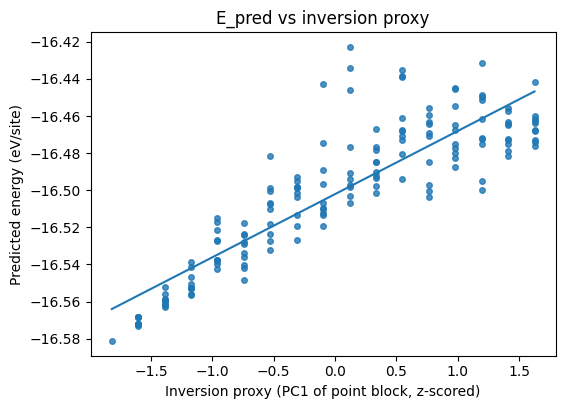

{'n_samples': 161,
 'n_features': 53,
 'n_point_cols': 2,
 'std_point_cols': [0.2902314732932418, 0.5804629465864836],
 'rank_const_points': 2,
 'point_ecis': [-33.22885863024174, -16.408340291938636],
 'pc1_var_explained': 1.0,
 'corr_true_vs_proxy': 0.8785240235229679,
 'corr_pred_vs_proxy': 0.8787130983143149,
 'slope_true_cell': 0.20425731174819758,
 'slope_pred_cell': 0.2042573117477348,
 'slope_true_site': 0.03404288529136626,
 'slope_pred_site': 0.03404288529128913}

In [ ]:
# ======================= CE inversion diagnostics (Jupyter block) =======================
from __future__ import annotations  # (safe in notebook; remove if you prefer)
from typing import Any, Mapping, Sequence, Tuple, cast
import math
import numpy as np
from numpy.typing import NDArray
import warnings

import matplotlib.pyplot as plt

from pymatgen.core import Structure
from smol.cofe import ClusterExpansion

# ---- phaseedge / your helpers (already in your session) ----
from phaseedge.jobs.store_ce_model import lookup_ce_by_key
from phaseedge.jobs.train_ce import (
    featurize_structures,
    lookup_train_refs_by_key,
    predict_from_features,
    _n_replace_sites_from_prototype,
)
from phaseedge.science.prototypes import PrototypeName
from phaseedge.schemas.mixture import sublattices_from_mixtures
from phaseedge.utils.keys import occ_key_for_structure
from phaseedge.storage.store import lookup_total_energy_eV


def _get_sublattices_from_doc(doc: Mapping[str, Any]) -> dict[str, tuple[str, ...]]:
    """Recover replaceable sublattices from CE doc (composition or wl_refined)."""
    sources = cast(Sequence[Mapping[str, Any]], doc.get("sources", []))
    if not sources:
        raise RuntimeError("CE document missing 'sources'.")
    s0 = sources[0]
    s_type = str(s0.get("type", "")).lower()
    if s_type == "composition":
        mixes: list[Mapping[str, Any]] = []
        for s in sources:
            if str(s.get("type", "")).lower() != "composition":
                continue
            mixes.extend(cast(Sequence[Mapping[str, Any]], s.get("mixtures", [])))
        if not mixes:
            raise RuntimeError("No composition mixtures found in CE 'sources'.")
        # Build a minimal Mixture-like dict for sublattice recovery
        ms = [{"composition_map": dict(m["composition_map"]), "K": int(m["K"]), "seed": int(m["seed"])} for m in mixes]
        return sublattices_from_mixtures([type("M", (), {"composition_map": m["composition_map"], "K": m["K"], "seed": m["seed"]}) for m in ms])  # type: ignore[misc]
    if s_type.startswith("wl_refined"):
        base_key = cast(str, s0["base_ce_key"])
        base_doc = lookup_ce_by_key(base_key)
        if not base_doc:
            raise RuntimeError(f"Base CE not found for wl_refined source: {base_key}")
        return _get_sublattices_from_doc(base_doc)
    raise RuntimeError(f"Unsupported source type in CE doc: {s_type!r}")


def _first_pair_col(cs) -> int:
    """Index where degree-2 block starts. Returns X.shape[1] if no pairs exist."""
    deg2 = cs.orbits_by_size.get(2, [])
    if deg2:
        return int(deg2[0].bit_id)
    # Fallback: assume all after constant+points (rare edge case with no pairs)
    return int(getattr(cs, "n_functions", 0) or 0)


def _rank(a: NDArray[np.float64], tol: float = 1e-12) -> int:
    s = np.linalg.svd(a, compute_uv=False, hermitian=False)
    return int(np.sum(s > tol))


def _fit_line(x: NDArray[np.float64], y: NDArray[np.float64]) -> Tuple[float, float]:
    """
    Ordinary least squares fit: y ≈ b0 + b1 * x
    Returns (intercept, slope).
    """
    X = np.column_stack([np.ones_like(x), x])
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    return float(beta[0]), float(beta[1])


def analyze_ce_inversion_signal(
    ce_key: str,
    *,
    plot: bool = True,
    verbose: bool = True,
) -> dict[str, Any]:
    """
    Inspect whether a CE encodes an A↔B sublattice preference using only the stored training set.

    Returns a dict of metrics; optionally draws a scatter of E vs inversion proxy.
    """
    # ---------- 1) Load CE doc + training set ----------
    doc = lookup_ce_by_key(ce_key)
    if not doc:
        raise RuntimeError(f"No CE found for ce_key={ce_key}")
    ce: ClusterExpansion = ClusterExpansion.from_dict(cast(Mapping[str, Any], doc["payload"]))
    cs = ce.cluster_subspace

    # Training configuration
    prototype = PrototypeName(doc["prototype"])
    proto_params = cast(Mapping[str, Any], doc["prototype_params"])
    sx, sy, sz = (int(x) for x in doc["supercell_diag"])
    supercell_diag = (sx, sy, sz)
    n_prims = int(np.prod(np.asarray(supercell_diag, dtype=int)))
    design = cast(Mapping[str, Any] | None, doc.get("design_metrics"))

    # Sublattices (for per-site scaling only; we do NOT need them to compute the proxy)
    sublattices = _get_sublattices_from_doc(doc)

    # Gather structures + energies in the recorded order
    train_refs = lookup_train_refs_by_key(doc["dataset_key"])
    if not train_refs:
        raise RuntimeError("CE document has no 'train_refs'.")

    structs: list[Structure] = []
    E_super: list[float] = []
    model_top = cast(str, doc["model"])
    relax_top = bool(doc["relax_cell"])
    dtype_top = cast(str, doc["dtype"])

    for i, r in enumerate(train_refs):
        pmg_struct = Structure.from_dict(r["structure"])
        # Safety: check occ_key remains consistent with hashing routine
        ok2 = occ_key_for_structure(pmg_struct)
        if ok2 != r["occ_key"]:
            raise RuntimeError(f"train_refs[{i}] occ_key mismatch; structure hashing changed.")
        structs.append(pmg_struct)
        e = lookup_total_energy_eV(
            set_id=cast(str, r["set_id"]),
            occ_key=cast(str, r["occ_key"]),
            model=cast(str, r.get("model", model_top)),
            relax_cell=bool(r.get("relax_cell", relax_top)),
            dtype=cast(str, r.get("dtype", dtype_top)),
        )
        if e is None:
            raise RuntimeError(f"Energy missing for train_refs[{i}]")
        E_super.append(float(e))

    # ---------- 2) Build features on THESE structures ----------
    _, X = featurize_structures(subspace=cs, structures=structs, supercell_diag=supercell_diag)
    n_samples, n_features = int(X.shape[0]), int(X.shape[1])
    if n_samples != len(E_super):
        raise RuntimeError("Feature/energy row mismatch.")

    # Per-primitive true energies
    y_true_cell = (np.asarray(E_super, dtype=np.float64) / float(n_prims))
    # Per-site scale
    sites_super = _n_replace_sites_from_prototype(
        prototype=prototype, prototype_params=proto_params,
        supercell_diag=supercell_diag, sublattices=sublattices
    )
    if sites_super % n_prims != 0:
        raise RuntimeError("sites_per_supercell not divisible by n_prims.")
    sites_per_prim = int(sites_super // n_prims)
    scale_site = 1.0 / float(sites_per_prim)

    # ---------- 3) Locate point block (degree-1) ----------
    first_pair_col = _first_pair_col(cs)  # index where degree-2 begins
    n_point_cols = max(0, first_pair_col - 1)
    if n_point_cols == 0:
        warnings.warn("No degree-1 (point) block found; CE cannot encode sublattice preference.")
    X_const = np.ones((n_samples, 1), dtype=np.float64)
    X_point = X[:, 1:first_pair_col].astype(np.float64, copy=False) if n_point_cols > 0 else np.zeros((n_samples, 0))
    # CE coefficients (stored)
    coefs = np.asarray(getattr(ce, "coefs", getattr(ce, "coefficients", None)), dtype=np.float64)
    if coefs is None or coefs.size != n_features:
        raise RuntimeError("CE coefficients missing or length mismatch.")
    w_point = coefs[1:first_pair_col] if n_point_cols > 0 else np.array([], dtype=np.float64)

    # ---------- 4) Basic diagnostics on point block ----------
    std_point = X_point.std(axis=0) if n_point_cols > 0 else np.array([], dtype=np.float64)
    rank_cp = _rank(np.hstack([X_const, X_point])) if n_point_cols > 0 else 1

    # ---------- 5) Inversion proxy from point block (PCA on centered points) ----------
    # We purposefully stay basis-agnostic: center point columns and take the top PC.
    if n_point_cols >= 1:
        Xp = X_point - X_point.mean(axis=0, keepdims=True)
        # If the sum direction is constant (fixed stoichiometry), PC1 ≈ "difference between sublattices".
        U, S, Vt = np.linalg.svd(Xp, full_matrices=False)
        var_explained = (S**2) / max(1e-30, np.sum(S**2))
        pc1 = Vt[0]  # shape (n_point_cols,)
        inv_proxy = Xp @ pc1  # shape (n_samples,)
        inv_proxy = inv_proxy.astype(np.float64, copy=False)
        # Normalize proxy to ~[-1,1] for readable slopes
        if inv_proxy.std() > 0:
            inv_proxy = inv_proxy / float(inv_proxy.std())
    else:
        inv_proxy = np.zeros(n_samples, dtype=np.float64)
        var_explained = np.array([], dtype=np.float64)

    # ---------- 6) Energies: predicted and true ----------
    y_pred_cell = predict_from_features(X, coefs)
    # Per-site versions (for interpretable magnitudes)
    y_pred_site = y_pred_cell * scale_site

    # Correlations and slopes vs inversion proxy
    def _safe_corr(a: NDArray[np.float64], b: NDArray[np.float64]) -> float:
        if a.std() == 0 or b.std() == 0:
            return float("nan")
        return float(np.corrcoef(a, b)[0, 1])

    corr_true = _safe_corr(y_true_cell, inv_proxy)
    corr_pred = _safe_corr(y_pred_cell, inv_proxy)
    b0_true, slope_true_cell = _fit_line(inv_proxy, y_true_cell) if inv_proxy.std() > 0 else (float("nan"), float("nan"))
    b0_pred, slope_pred_cell = _fit_line(inv_proxy, y_pred_cell) if inv_proxy.std() > 0 else (float("nan"), float("nan"))
    # Per-site slopes
    slope_true_site = slope_true_cell * scale_site if math.isfinite(slope_true_cell) else float("nan")
    slope_pred_site = slope_pred_cell * scale_site if math.isfinite(slope_pred_cell) else float("nan")

    # ---------- 7) Report ----------
    if verbose:
        print("═" * 76)
        print(" CE Inversion Diagnostics ".center(76, "═"))
        print("═" * 76)
        print(f"CE key              : {ce_key}")
        print(f"samples / features  : {n_samples} / {n_features}")
        print(f"supercell_diag      : {supercell_diag} (n_prims={n_prims}, sites/prim={sites_per_prim})")
        print("-" * 76)
        print(f"degree-1 block cols : {n_point_cols}  (expected ≥ 2 for two cation sublattices)")
        if n_point_cols > 0:
            print(f"std(point cols)     : " + (", ".join(f"{v:.3e}" for v in std_point)))
            print(f"rank([1|points])    : {rank_cp} (max {1 + n_point_cols})")
            print(f"point ECIs (degree-1): " + (", ".join(f"{v:.6g}" for v in w_point)))
        else:
            print("No point features present; CE cannot encode sublattice preference.")
        print("-" * 76)
        if n_point_cols >= 1:
            print(f"PC1 var explained   : {var_explained[0]:.3f}  (proxy spans the dominant point variation)")
            print(f"corr(E_true , proxy): {corr_true:.3f}")
            print(f"corr(E_pred , proxy): {corr_pred:.3f}")
            print(f"dE_true / dProxy    : {slope_true_cell:.6g} eV/prim   ({slope_true_site*1e3:.3f} meV/site)")
            print(f"dE_pred / dProxy    : {slope_pred_cell:.6g} eV/prim   ({slope_pred_site*1e3:.3f} meV/site)")
        else:
            print("PC1 / proxy not available (no point block).")
        print("═" * 76)

    # ---------- 8) Optional plot ----------
    if plot and n_point_cols >= 1 and inv_proxy.std() > 0:
        fig, ax = plt.subplots(figsize=(6, 4.2))
        ax.scatter(inv_proxy, y_pred_site, s=16, alpha=0.8)
        # Fit line in per-site units for readability
        _, slope_ps = _fit_line(inv_proxy, y_pred_site)
        xs = np.linspace(inv_proxy.min(), inv_proxy.max(), 100)
        ax.plot(xs, (y_pred_site.mean() - slope_ps * inv_proxy.mean()) + slope_ps * xs)
        ax.set_xlabel("Inversion proxy (PC1 of point block, z-scored)")
        ax.set_ylabel("Predicted energy (eV/site)")
        ax.set_title("E_pred vs inversion proxy")
        plt.show()

    # ---------- 9) Return structured metrics ----------
    return {
        "n_samples": n_samples,
        "n_features": n_features,
        "n_point_cols": n_point_cols,
        "std_point_cols": std_point.tolist() if n_point_cols > 0 else [],
        "rank_const_points": int(rank_cp),
        "point_ecis": w_point.tolist() if n_point_cols > 0 else [],
        "pc1_var_explained": float(var_explained[0]) if n_point_cols >= 1 else float("nan"),
        "corr_true_vs_proxy": float(corr_true),
        "corr_pred_vs_proxy": float(corr_pred),
        "slope_true_cell": float(slope_true_cell),
        "slope_pred_cell": float(slope_pred_cell),
        "slope_true_site": float(slope_true_site),
        "slope_pred_site": float(slope_pred_site),
    }


# ---------------- Example usage ----------------
analyze_ce_inversion_signal("d06be615f7a147f2230b86081feb8b57d39cc6dcd88592636283d3739643ca05", plot=True, verbose=True)
# metrics
# ========================================================================================
